In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, accuracy



import seaborn as sns

2021-05-18 16:30:13,466 -INFO - common:common.py:422 - Module utils.common is loaded...
2021-05-18 16:30:13,466 -INFO - dataset_builder:dataset_builder.py:16 - dataset package is loaded...
2021-05-18 16:30:13,480 -INFO - dataset:dataset.py:627 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=2231, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=21, bias=True)
)

## Load test dataset

In [5]:
# dataset_name = 'angular'
dataset_name = 'html-5'
# dataset_name = 'react-ant'
# dataset_name = 'mobile-and-html-5'
# dataset_name = 'bootstrap'
# dataset_name = 'dummy'
# dataset_name = 'google'
# dataset_name = 'cnews'

In [6]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-18 16:30:16,063 -INFO - dataset:dataset.py:235 - List of dataset_names:['html-5']
2021-05-18 16:30:16,064 -INFO - dataset:dataset.py:241 - Dataset for html-5
2021-05-18 16:30:16,137 -INFO - dataset:dataset.py:243 - Dataset shape: (665, 13)
2021-05-18 16:30:16,137 -INFO - dataset:dataset.py:245 - cleaning tag_name from dummy/auxiliary words
2021-05-18 16:30:16,137 -INFO - dataset:dataset.py:44 - select all leafs (nodes which are not parents)
2021-05-18 16:30:16,137 -INFO - dataset:dataset.py:47 - Leafs set size: 413 (nodes which have no children)
2021-05-18 16:30:16,143 -INFO - dataset:dataset.py:50 - count number of references to leafs
2021-05-18 16:30:16,144 -INFO - dataset:dataset.py:54 - Nodes with leafs as children set size: 165 (nodes which have leafs as children)
2021-05-18 16:30:16,145 -INFO - dataset:dataset.py:57 - count num children for each node
2021-05-18 16:30:16,146 -INFO - dataset:dataset.py:59 - Nodes with children: 253
2021-05-18 16:30:16,147 -INFO - dataset:da

  0%|          | 0/665 [00:00<?, ?it/s]

2021-05-18 16:30:17,453 -INFO - dataset:dataset.py:260 - Dataset shape after merging with parents: (665, 44)
2021-05-18 16:30:17,453 -WARNING - dataset:dataset.py:266 - Load LABELS from dataset/annotations/html-5.txt


Assigning labels:   0%|          | 0/118 [00:00<?, ?it/s]

2021-05-18 16:30:17,954 -INFO - dataset:dataset.py:282 - Concatenate datasets
2021-05-18 16:30:17,959 -INFO - dataset:dataset.py:284 - Dataset shape after reading: (665, 46)
2021-05-18 16:30:17,961 -WARNING - dataset:dataset.py:607 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-18 16:30:17,964 -INFO - dataset:dataset.py:624 - class_sm: (665, 779)
2021-05-18 16:30:17,965 -INFO - dataset:dataset.py:293 - Build OHE column for attribute role
2021-05-18 16:30:17,967 -INFO - dataset:dataset.py:293 - Build OHE column for attribute type
2021-05-18 16:30:17,970 -INFO - dataset:dataset.py:293 - Build OHE column for attribute ui
2021-05-18 16:30:17,972 -INFO - dataset:dataset.py:298 - Build OHE column for attribute role_parent
2021-05-18 16:30:17,975 -INFO - dataset:dataset.py:298 - Build OHE column for attribute type_parent
2021-05-18 16:30:17,977 -INFO - dataset:dataset.py:298 - Build OHE column for attribute ui_parent
2021-05-18 16:30:17,980 -INFO - 

In [7]:
dataset.dataset.shape

(665, 55)

In [8]:
dataset.labels

0       n/a
1       n/a
2       n/a
3       n/a
4       n/a
       ... 
660    link
661     n/a
662    link
663     n/a
664     n/a
Name: label, Length: 665, dtype: object

In [9]:
dataset.dataset.label

0      20
1      20
2      20
3      20
4      20
       ..
660     1
661    20
662     1
663    20
664    20
Name: label, Length: 665, dtype: int32

In [10]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [11]:
results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            y_pred = y_pred[0].argmax()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/665 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
660,1,1,link,link
661,20,20,n/a,n/a
662,1,1,link,link
663,20,20,n/a,n/a


In [12]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox',
 'textarea',
 'label',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'radiobutton',
 'table',
 'n/a']

In [13]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true_label.values,
                     y_pred=results_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [14]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox,textarea,label,text,fileinput,...,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,radiobutton,table,n/a
button,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,68,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
checkbox,0,0,0,0,1,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,2,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
text,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fileinput,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns


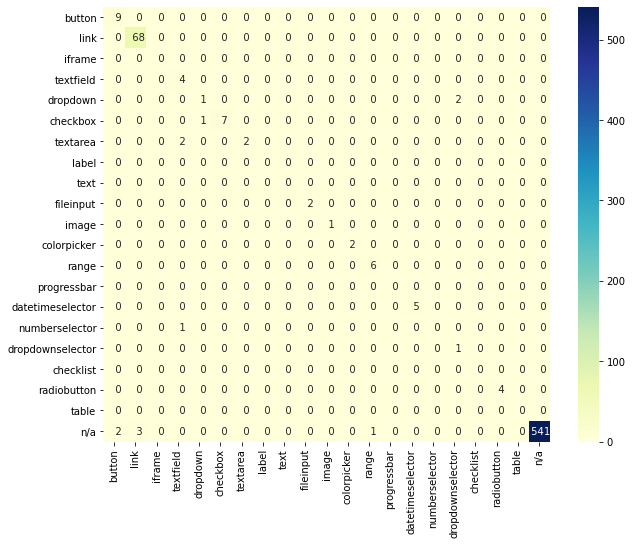

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [17]:
dataset_name

'html-5'

In [18]:
accuracy(results_df)

2021-05-18 16:30:20,120 -INFO - common:common.py:457 - Accuracy:  112/124 = 0.9032258064516129, for 665 elements


0.9032258064516129

In [19]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox': 5,
 'textarea': 6,
 'label': 7,
 'text': 8,
 'fileinput': 9,
 'image': 10,
 'colorpicker': 11,
 'range': 12,
 'progressbar': 13,
 'datetimeselector': 14,
 'numberselector': 15,
 'dropdownselector': 16,
 'checklist': 17,
 'radiobutton': 18,
 'table': 19,
 'n/a': 20}

In [20]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label


(6242, 1200)


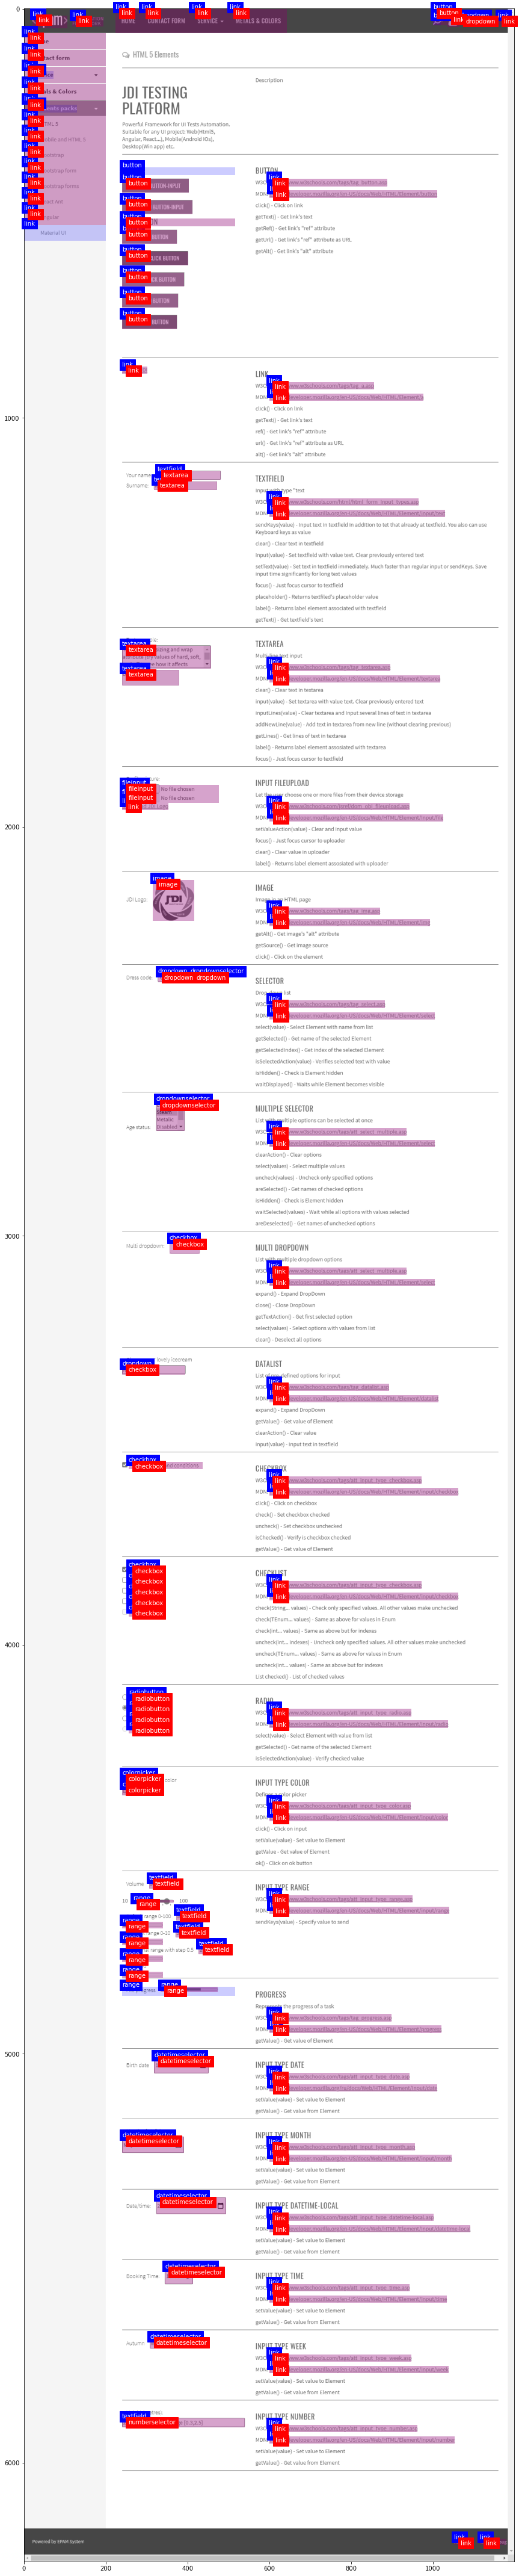

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [22]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,20,20,n/a,n/a
1,20,20,n/a,n/a
2,20,20,n/a,n/a
3,20,20,n/a,n/a
4,20,20,n/a,n/a
...,...,...,...,...
660,1,1,link,link
661,20,20,n/a,n/a
662,1,1,link,link
663,20,20,n/a,n/a


In [23]:
dataset.dataset[:1].to_json(orient='records')

'[{"attributes":{"accept":null,"alt":null,"charset":null,"checked":null,"class":null,"cols":null,"content":null,"data-placement":null,"data-toggle":null,"dir":null,"disabled":null,"download":null,"for":null,"height":null,"href":null,"http-equiv":null,"id":null,"index":null,"lang":"en","language":null,"list":null,"max":null,"maxlength":null,"min":null,"minlength":null,"multiple":null,"name":null,"onchange":null,"onclick":null,"oncontextmenu":null,"ondblclick":null,"oninput":null,"placeholder":null,"rel":null,"required":null,"role":null,"rows":null,"selected":null,"size":null,"src":null,"step":null,"style":null,"tabindex":null,"target":null,"title":null,"type":null,"ui":null,"value":null,"width":null,"wrap":null},"displayed":true,"element_id":"6194400565668651573001447234","height":6225.0,"onmouseenter":null,"onmouseover":null,"parent_id":"6194400565668651573001447234","style":["align-content","align-items","align-self","alignment-baseline","animation-delay","animation-direction","animat